In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Step 2: Load Cleaned Dataset
df = pd.read_csv("cleaned_behavior_features.csv")

In [ ]:
# Step 3: Recompute the target variable
df['converted'] = (df['event_name'] == 'purchase').astype(int)

In [ ]:
# Step 4: Add frequency-encoded features for user_id and item_id
df['user_activity_count'] = df['user_pseudo_id'].map(df['user_pseudo_id'].value_counts())
df['item_popularity'] = df['item_id'].map(df['item_id'].value_counts())

In [ ]:
# Step 5: Drop unused columns
df.drop(columns=[
    'user_pseudo_id', 'item_id', 'item_name', 'event_name',
    'discounted_price', 'event_date', 'region', 'city', 'country'
], inplace=True)

In [ ]:
# Step 6: Remove any rows with missing values (if any)
df = df[df['converted'].isin([0, 1])].copy()


In [ ]:
# Step 7: Define Features and Target
target = 'converted'
features = [
    'original_price', 'discount_percent', 'item_category', 'campaign_type', 'channel',
    'hour_of_day', 'day_of_week', 'days_since_first_event',
    'user_product_view_count', 'user_product_purchase_count', 'user_product_interaction_count',
    'user_activity_count', 'item_popularity'
]

In [ ]:
X = df[features]
y = df[target]

In [ ]:
# Step 8: Identify Categorical and Numerical Columns
categorical_cols = ['item_category', 'campaign_type', 'channel', 'day_of_week']
numerical_cols = [col for col in features if col not in categorical_cols]

In [ ]:
# Step 9: Preprocessing Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [ ]:
# Step 10: Define Models
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                             scale_pos_weight=(y == 0).sum() / (y == 1).sum(), random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}

In [ ]:
# Step 11: Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


🔍 Training Random Forest...

📊 Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9198
           1       0.24      0.01      0.02       802

    accuracy                           0.92     10000
   macro avg       0.58      0.50      0.49     10000
weighted avg       0.87      0.92      0.88     10000

🧮 Confusion Matrix for Random Forest


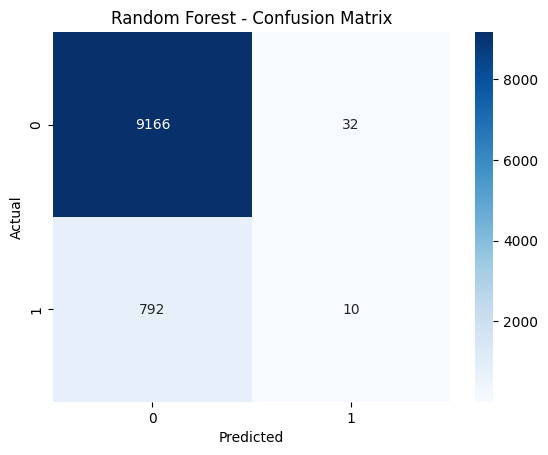

🔢 ROC-AUC Score: 0.6506

🔍 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:53:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Classification Report for XGBoost
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      9198
           1       0.14      0.40      0.21       802

    accuracy                           0.75     10000
   macro avg       0.54      0.59      0.53     10000
weighted avg       0.87      0.75      0.80     10000

🧮 Confusion Matrix for XGBoost


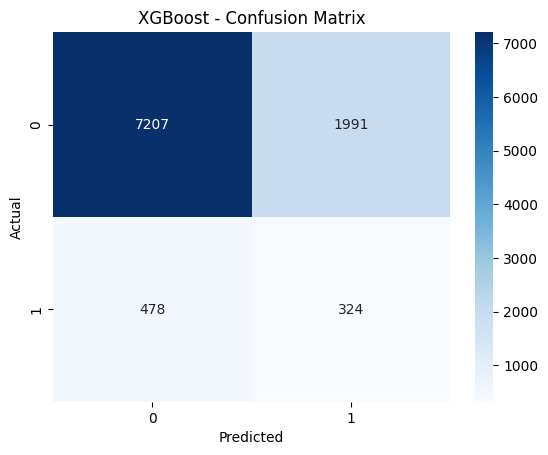

🔢 ROC-AUC Score: 0.6183

🔍 Training Neural Network...

📊 Classification Report for Neural Network
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      9198
           1       0.14      0.15      0.14       802

    accuracy                           0.86     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.86      0.86      0.86     10000

🧮 Confusion Matrix for Neural Network


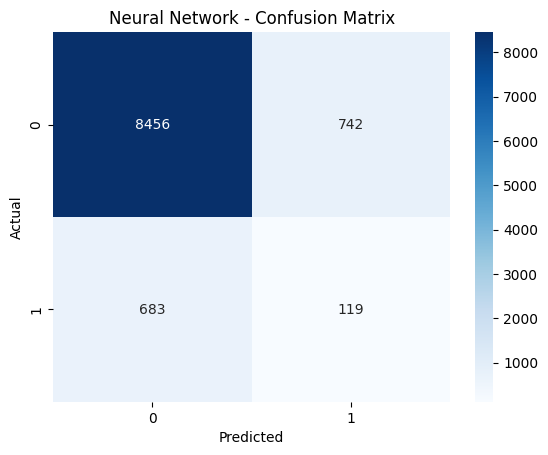

🔢 ROC-AUC Score: 0.5835


In [ ]:
# Step 12: Train Models and Evaluate
results = {}

for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    pipeline = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    print(f"\n📊 Classification Report for {name}")
    print(classification_report(y_test, y_pred))

    print(f"🧮 Confusion Matrix for {name}")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"🔢 ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")